# Sequential Data transformations

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from Modules import *
sns.set()
%matplotlib inline

In [2]:
df, y = read_data('default_of_credit_card_clients.xls')
df = proc_cat_df(df)


df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT5,PAY_AMT6,Y,SEX_Female,SEX_Male,EDUCATION_Graduate School,EDUCATION_Other,EDUCATION_University,MARRIAGE_Married,MARRIAGE_Non-married
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,0,1,1,0,0,0,1,1,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,0,2000,1,1,0,0,0,1,0,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,5000,0,1,0,0,0,1,0,1
4,50000,37,0,0,0,0,0,0,46990,48233,...,1069,1000,0,1,0,0,0,1,1,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,689,679,0,0,1,0,0,1,1,0


In [3]:
df_copy =  df.iloc[:, 2:20].copy()
df_copy.head(10)

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
1,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
2,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679
6,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800
7,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770
8,0,-1,-1,0,0,-1,11876,380,601,221,-159,567,380,601,0,581,1687,1542
9,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000
10,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0


## TO DO:

need to make a baseline classifier; probably just a basic xgboost

In [6]:
evaluate_baseline(df)

[0.39505523 0.38090269 0.37832204 0.39427083 0.38897556 0.37911943
 0.77829228 0.96608915 0.96883769 0.96193875]

corss-validation f1 score: 0.5991803644123295


## Baseline Classifier

This cell below is the base evaluation of the above dataframe, and will be the same for Martin's new data that he has created

In [5]:
def XGB_evaluate(df):
    '''baseline xgboos classifier for investigating creating new sequential data.
    Input: a dataframe with desired features. Target feature must be labled as "Y".
    Ouput: 50-fold cross validation with auc and mean-avg-precision scores.
    The process is a follows:
    #1: split data into a train & test split
    #2: create oversampled data, set a dmatrix. Will use this to train the XGBoost model.
    #3: train XGBoost.cv on the oversampled dmatrix
    '''
    import xgboost as xgb
    from sklearn.model_selection import train_test_split, KFold, cross_val_score
    import sklearn.metrics
    from imblearn.over_sampling import RandomOverSampler

    #1
    X = df.drop(columns = ['Y'])
    y = df['Y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)

    #2
    oversampler = RandomOverSampler(random_state = 2019)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    data_dmatrix = xgb.DMatrix(data=X_train_oversampled,label=y_train_oversampled)

    #3
    params = {"objective":'binary:logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

    #put results as a pandas dataframe
    #will track auc and mean avg precision (map), as a proxy for f1 score
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics=["auc", 'map'],as_pandas=True, seed=2019)
    
    return cv_results



In [6]:
#run XGBoost with naive oversampling, as in function above
cv_results = XGB_evaluate(df)

Text(30,0.75,'final auc-mean score: 0.79971')

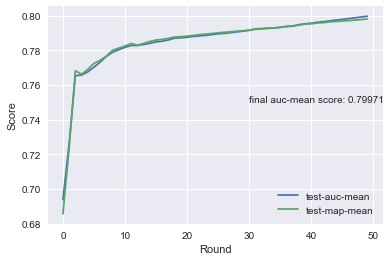

In [7]:
cv_results[['test-auc-mean', 'test-map-mean']].plot()
plt.xlabel('Round')
plt.ylabel('Score')
plt.annotate(xy = (30,.75), s='final auc-mean score: ' +str(cv_results['test-auc-mean'][49]))

In [ ]:
#run the same procudure using SMOTE 
#using function in `Modules.py`
cv_SMOTE_results = XGBoost_evaluate(df)

Text(20,0.86,'final auc-mean score: 0.9075653333333333')

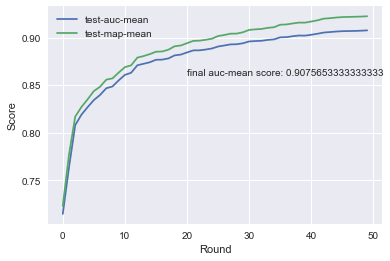

In [9]:
cv_SMOTE_results[['test-auc-mean', 'test-map-mean']].plot()
plt.xlabel('Round')
plt.ylabel('Score')
plt.annotate(xy = (20,.86), s='final auc-mean score: ' +str(cv_SMOTE_results['test-auc-mean'][49]))